In [1]:
import argparse
import pathlib

import matplotlib.pyplot as plt

# Import dependencies
import numpy as np
import skimage
import tifffile

# check if in a jupyter notebook
try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

print(in_notebook)

True


In [2]:
if not in_notebook:
    # set up arg parser
    parser = argparse.ArgumentParser(description="Segment the nuclei of a tiff image")

    parser.add_argument(
        "--patient",
        type=str,
        help="Patient ID to use for the segmentation",
    )

    parser.add_argument(
        "--well_fov",
        type=str,
        help="Path to the input directory containing the tiff images",
    )

    parser.add_argument(
        "--clip_limit",
        type=float,
        help="Clip limit for the adaptive histogram equalization",
    )

    args = parser.parse_args()
    clip_limit = args.clip_limit
    well_fov = args.well_fov
    patient = args.patient

else:
    well_fov = "C4-2"
    clip_limit = 0.1
    patient = "NF0014"


input_dir = pathlib.Path(f"../../data/{patient}/zstack_images/{well_fov}").resolve(
    strict=True
)

mask_path = pathlib.Path(f"../../data/{patient}/processed_data/{well_fov}").resolve()
nuclei_mask_output = mask_path / "nuclei_masks_watershed.tiff"
mask_path.mkdir(exist_ok=True, parents=True)

## Set up images, paths and functions

In [3]:
image_extensions = {".tif", ".tiff"}
files = sorted(input_dir.glob("*"))
files = [str(x) for x in files if x.suffix in image_extensions]

In [4]:
# find the cytoplasmic channels in the image set
for f in files:
    if "405" in f:
        nuclei = tifffile.imread(f)

In [16]:
nuclei_mask = tifffile.imread(
    pathlib.Path(
        f"../../data/NF0014/processed_data/{well_fov}/nuclei_masks_reconstructed_corrected.tiff"
    )
)

In [17]:
test_image = nuclei_mask.copy()

In [18]:
test_image = skimage.morphology.erosion(test_image, skimage.morphology.ball(1))

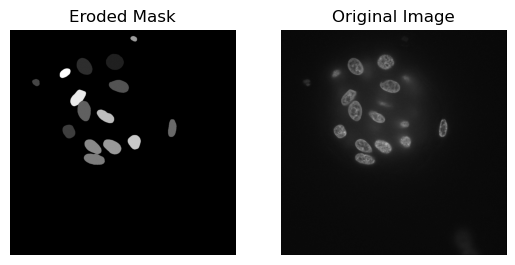

In [19]:
plt.subplot(1, 2, 1)
plt.imshow(test_image[4, :, :], cmap="gray")
plt.title("Eroded Mask")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(nuclei[4, :, :], cmap="gray")
plt.title("Original Image")
plt.axis("off")
plt.show()

In [ ]:
# binarize the nuclei mask
binary_nuclei_mask = nuclei_mask > 0
# ensure that no nuclei masks are touching each other

In [7]:
# set up seeded watersheding where the nuclei masks are used as seeds
# the sytoplasm is signal

labels = skimage.segmentation.watershed(
    image=nuclei,
    markers=nuclei_mask,
    mask=binary_nuclei_mask,
)

In [8]:
# change the largest label (by area) to 0
unique, counts = np.unique(labels, return_counts=True)
largest_label = unique[np.argmax(counts)]
labels[labels == largest_label] = 0

In [9]:
# save the labels as a tiff file
tifffile.imwrite(mask_path / "nuclei_masks_watershed.tiff", labels)

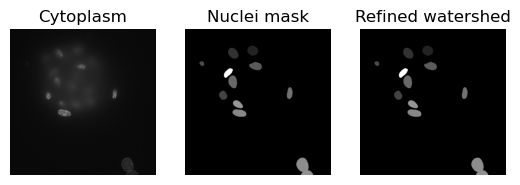

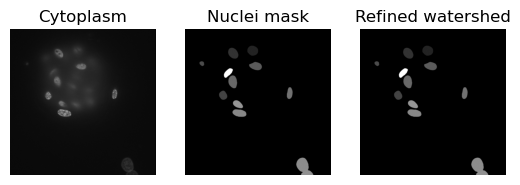

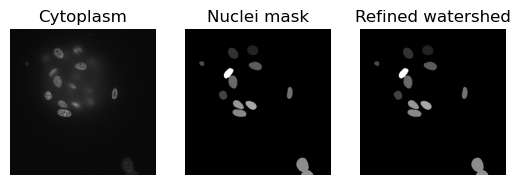

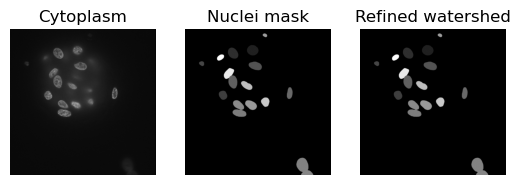

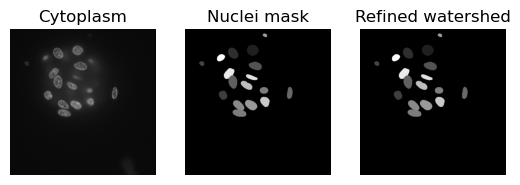

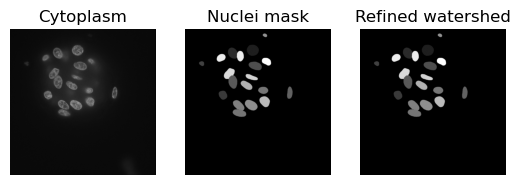

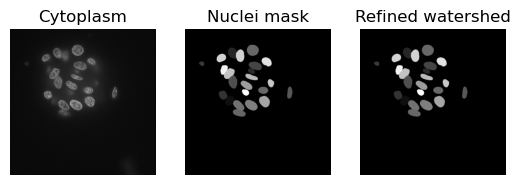

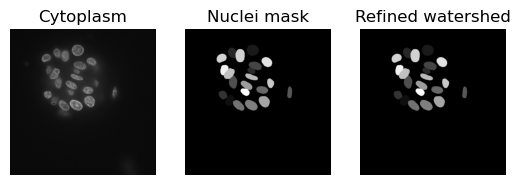

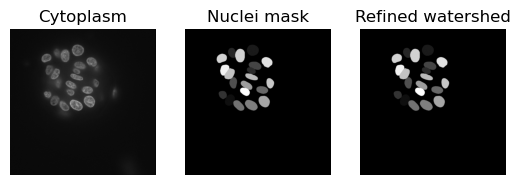

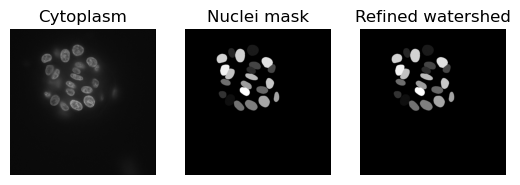

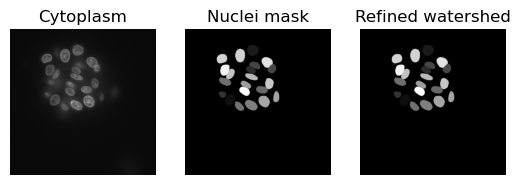

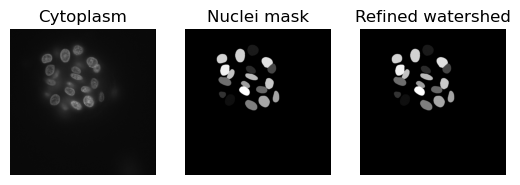

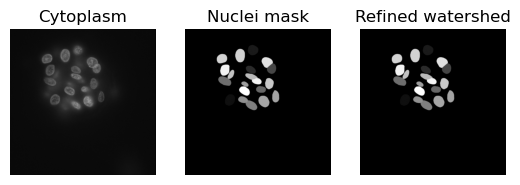

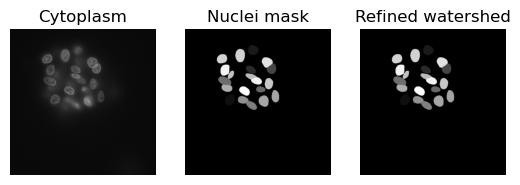

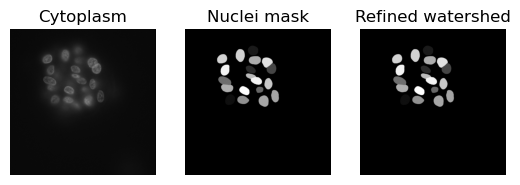

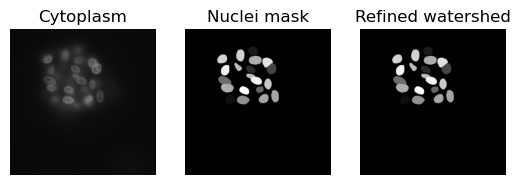

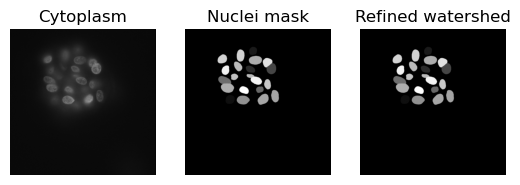

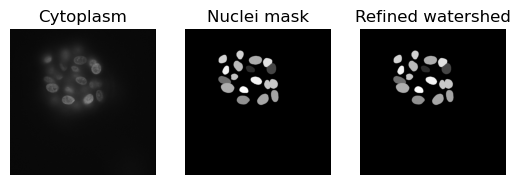

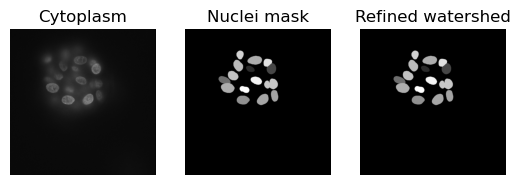

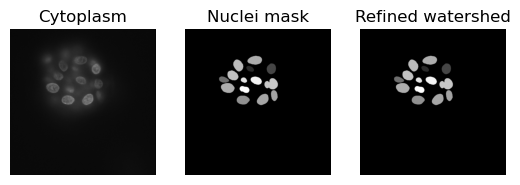

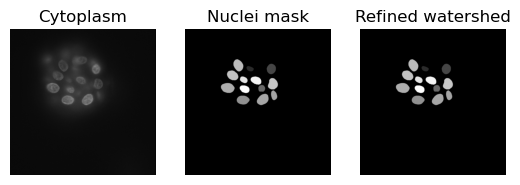

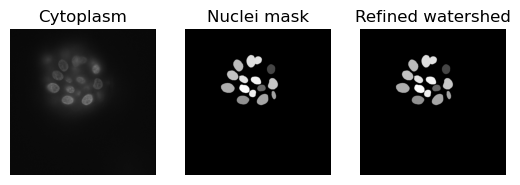

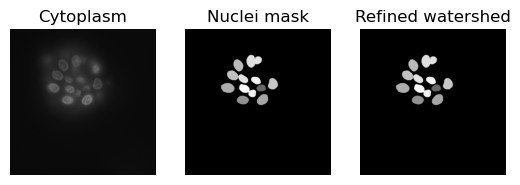

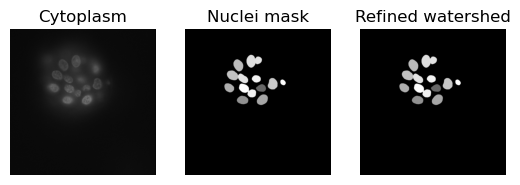

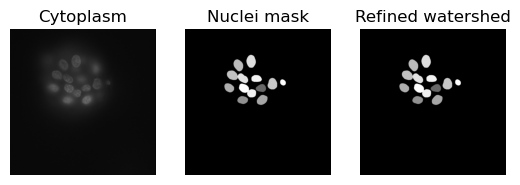

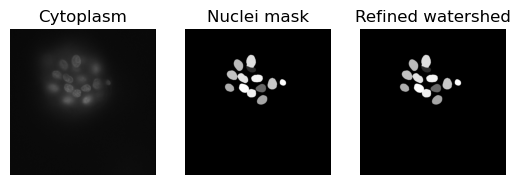

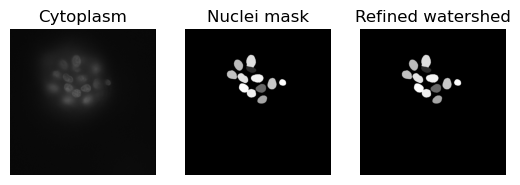

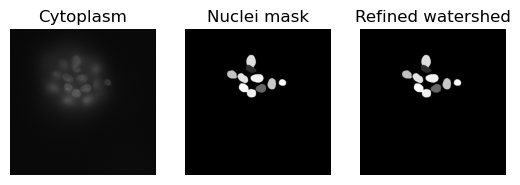

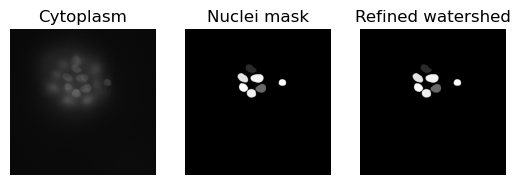

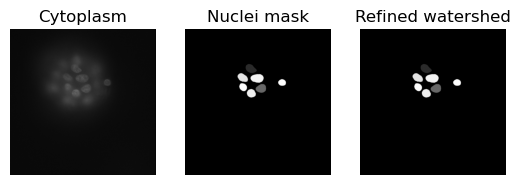

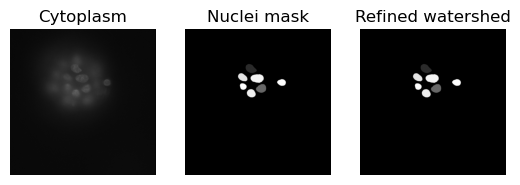

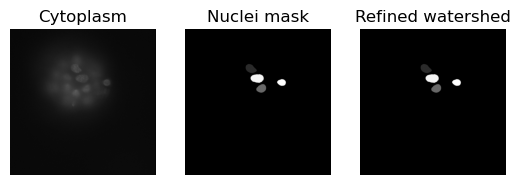

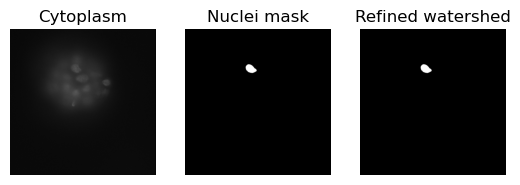

In [10]:
for z in range(nuclei.shape[0]):
    plt.subplot(1, 3, 1)
    plt.imshow(nuclei[z, :, :], cmap="gray")
    plt.title("Cytoplasm")
    plt.axis("off")
    plt.subplot(1, 3, 2)
    plt.imshow(nuclei_mask[z, :, :], cmap="gray")
    plt.title("Nuclei mask")
    plt.axis("off")
    plt.subplot(1, 3, 3)
    plt.imshow(labels[z, :, :], cmap="gray")
    plt.title("Refined watershed")
    plt.axis("off")
    plt.show()